# MERS

In [3]:
import sys
sys.path.append("../notebooks/")

# Imports Section 

In [4]:
import altair as alt
import Bio.Phylo
import json
import matplotlib.pyplot as plt
import pandas as pd
import re
import seaborn as sns

from Helpers import linking_tree_with_plots_clickable, linking_tree_with_plots_brush, scatterplot_with_tooltip_interactive
from Helpers import get_y_positions

%matplotlib inline

In [64]:
try: 
    snakemake.input.node_df
    import selenium
    from selenium.webdriver import Chrome 
    from selenium import webdriver

    chrome_options = webdriver.ChromeOptions()
    chrome_options.add_argument('--headless')
    chrome_options.add_argument('--no-sandbox')
    chrome_options.add_argument('--disable-dev-shm-usage')
    chrome_options.add_argument("--remote-debugging-port=9222")

    browser = webdriver.Chrome(options=chrome_options)
except:
    print("not in Snakemake, imports unnecessary")

not in Snakemake, imports unnecessary


# MERS Specific Variables

In [7]:
try:
    node_df = snakemake.input.node_df

    pca_df = snakemake.input.pca_df
    explained_variance_pca = snakemake.input.explained_variance_pca

    mds_df = snakemake.input.mds_df

    #Scatterplot:
    scatterplot_pca = snakemake.input.scatterplot_pca
    scatterplot_pca_metadata = snakemake.input.scatterplot_pca_metadata

    scatterplot_mds = snakemake.input.scatterplot_mds
    scatterplot_mds_metadata = snakemake.input.scatterplot_mds_metadata

    scatterplot_tsne = snakemake.input.scatterplot_tsne
    scatterplot_tsne_metadata = snakemake.input.scatterplot_tsne_metadata

    scatterplot_umap = snakemake.input.scatterplot_umap
    scatterplot_umap_metadata = snakemake.input.scatterplot_umap_metadata

    #KDE Density:
    KDE_pca = snakemake.input.KDE_pca
    KDE_pca_metadata = snakemake.input.KDE_pca_metadata

    KDE_mds = snakemake.input.KDE_mds
    KDE_mds_metadata = snakemake.input.KDE_mds_metadata

    KDE_tsne = snakemake.input.KDE_tsne
    KDE_tsne_metadata = snakemake.input.KDE_tsne_metadata

    KDE_umap = snakemake.input.KDE_umap
    KDE_umap_metadata = snakemake.input.KDE_umap_metadata
    
    KDE_genetic = snakemake.input.KDE_genetic
    KDE_genetic_metadata = snakemake.input.KDE_genetic_metadata
except:
    print("not in Snakemake, imports unnecessary")

not in Snakemake, imports unnecessary


# Trying out MERS

In [6]:
#node_df = pd.read_csv(node_df, sep="\t")
node_df = pd.read_csv("results/table.tsv", sep="\t")
node_df.rename(columns={'num_date':'date', 'y_value':"y"}, inplace=True)
node_df = node_df.take(node_df["clade_membership"].dropna().index.values.tolist())

In [7]:
node_df

,strain,date,pca1,pca2,mds1,mds2,tsne_x,tsne_y,umap_x,umap_y,host,clade_membership,pca_label,mds_label,umap_label,t-sne_label,y
0,EMC/2012|JX869059|human|2012-06-13,2012.45,-15.75,-1.40,-35.25,27.04,13.71,-1.08,2.14,13.58,human,clade_0,2,-1,3,0,1
1,Jordan-N3/2012|KC776174|human|2012-04-15,2012.29,-15.06,-1.71,-12.50,9.44,12.85,-1.59,2.29,13.61,human,clade_0,-1,-1,3,0,2
2,D998/15|KX108943|camel|2015-04-23,2015.31,-15.38,-1.17,-62.34,73.71,10.74,-1.24,2.98,13.25,camel,clade_1,-1,-1,3,0,3
3,NRCE-HKU205|KJ477102|camel|2013-11-15,2013.87,-13.24,-1.92,-28.37,54.19,12.01,1.07,2.68,13.52,camel,clade_1,1,-1,3,0,4
4,Egypt_NRCE-NC163/2014|KU740200|camel|2014-12-17,2014.96,-12.29,-2.76,-41.42,51.25,12.06,2.60,2.78,12.97,camel,clade_1,1,-1,3,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269,KOR/CNUH_SNU/024_06_2015|KT868867|human|2015-0...,2015.43,-15.51,-1.61,24.50,-28.11,-26.43,-5.82,14.15,12.16,human,clade_32,-1,2,0,1,270
270,KOR/CNUH_SNU/030_06_2015|KT868868|human|2015-0...,2015.43,-15.52,-1.62,24.52,-28.17,-25.77,-5.67,13.82,12.29,human,clade_32,-1,2,0,1,271
271,KOR/CNUH_SNU/023_06_2015|KT868866|human|2015-0...,2015.44,-15.52,-1.62,24.52,-28.17,-26.43,-5.82,14.28,12.53,human,clade_32,-1,2,0,1,272
272,KOR/CNUH_SNU/031_06_2015|KT868869|human|2015-0...,2015.44,-15.51,-1.62,24.52,-28.16,-25.78,-5.69,13.60,12.16,human,clade_32,-1,2,0,1,273


In [61]:
node_df["strain"].value_counts().sort_values(ascending=False)

Jeddah/O24/2014|KT368850|camel|2014-10                1
Jeddah/O23b/2014|KT368849|camel|2014-10               1
KOR/CNUH_SNU/085_06_2015|KT868873|human|2015-06-10    1
Riyadh-KKUH-368||human|2014-05-13                     1
Jeddah/D43b/2014|KT368836|camel|2014-12               1
                                                     ..
Riyadh_KKUH_0818||human|2015-02-28                    1
KFMC-6|KT121576|human|2014-05-18                      1
KFMC-10|KT121578|human|2014-05-01                     1
Riyadh_KKUH_1522||human|2015-03-09                    1
Al-Hasa_14_2013|KF600615|human|2013-05-08             1
Name: strain, Length: 226, dtype: int64

# Running PCA on the Dataset

In [62]:
principalDf = pd.read_csv(pca_df, index_col=0)
explained_variance_df = pd.read_csv(explained_variance_pca)

In [ ]:
chart = alt.Chart(explained_variance_df).mark_line().encode(
    x='principal components:Q',
    y='explained variance:Q'
)
chart.save(snakemake.output.Explained_variance_PCA)

In [63]:
merged_pca_df = principalDf.merge(node_df[["strain", "date", "y", "host", "clade_membership"]], on="strain")

In [64]:
explained_variance_PCA = explained_variance_df["explained variance"].values.tolist()

In [65]:
PCAFluBrush = scatterplot_with_tooltip_interactive(merged_pca_df,'pca1','pca2','PCA1 (Explained Variance : {}%'.format(round(explained_variance_PCA[0]*100,2)) + ")",
                                          'PCA2 (Explained Variance : {}%'.format(round(explained_variance_PCA[1]*100,2)) + ")",['strain'],'clade_membership:N')
PCAFluBrush

alt.Chart(...)

In [66]:
list_of_chart = linking_tree_with_plots_brush(merged_pca_df,['pca1','pca2','pca3','pca4', 'pca5', 'pca6'],
                                         ['PCA1 (Explained Variance : {}%'.format(round(explained_variance_PCA[0]*100,2)) + ")",
                                          'PCA2 (Explained Variance : {}%'.format(round(explained_variance_PCA[1]*100,2)) + ")",
                                          'PCA3 (Explained Variance : {}%'.format(round(explained_variance_PCA[2]*100,2)) + ")",
                                          'PCA4 (Explained Variance : {}%'.format(round(explained_variance_PCA[3]*100,2)) + ")",
                                          'PCA5 (Explained Variance : {}%'.format(round(explained_variance_PCA[4]*100,2)) + ")",
                                          'PCA6 (Explained Variance : {}%'.format(round(explained_variance_PCA[5]*100,2)) + ")"],
                                         "clade_membership:N",['strain', "host"])
chart_pca = list_of_chart[0]|list_of_chart[1]|list_of_chart[2]

chart_pca

alt.HConcatChart(...)

# Running MDS on Dataset

In [67]:
MDS_df = pd.read_csv(mds_df,index_col=0)
merged_mds_df = MDS_df.merge(node_df[["strain", "date", "y", "host", "clade_membership"]], on="strain")

In [68]:
scatterplot_with_tooltip_interactive(merged_mds_df,'mds1','mds2',"mds1","mds2",['strain'],'clade_membership:N')

alt.Chart(...)

In [69]:
list_of_chart = linking_tree_with_plots_brush(merged_mds_df,['mds1','mds2'],["MDS1", "MDS2"], 'clade_membership:N', ['strain'])
chart_mds = list_of_chart[0]|list_of_chart[1]

In [70]:
chart_mds

alt.HConcatChart(...)

# Running t-SNE on the Dataset

In [88]:
TSNE_df = node_df[["strain", "date", "y", "host", "clade_membership", "tsne_x", "tsne_y", "t-sne_label"]]

In [91]:
scatterplot_with_tooltip_interactive(TSNE_df,'tsne_x','tsne_y','tsne_x','tsne_y',['strain', "clade_membership"],'clade_membership:N')

alt.Chart(...)

In [92]:
list_of_chart = linking_tree_with_plots_brush(
    TSNE_df,
    ['tsne_x','tsne_y'],
    ['tsne_x','tsne_y'],
    'clade_membership:N',
    ["host:N","strain:N"]
)
chart_tsne = list_of_chart[0]|list_of_chart[1]
chart_tsne

alt.HConcatChart(...)

In [ ]:
list_of_chart = linking_tree_with_plots_brush(
    TSNE_df,
    ['tsne_x','tsne_y'],
    ['tsne_x','tsne_y'],
    't-sne_label:N',
    ["host:N","strain:N"],
    domain,
    range_
)
chart_tsne = list_of_chart[0]|list_of_chart[1]
chart_tsne

# Running UMAP on the Dataset

In [93]:
UMAP_df = node_df[["strain", "date", "y", "host", "clade_membership", "umap_x", "umap_y"]]

In [95]:
scatterplot_with_tooltip_interactive(UMAP_df,'umap_x','umap_y','umap_x','umap_y',['strain'],'clade_membership:N')

alt.Chart(...)

In [96]:
list_of_data_and_titles = ['umap_x','umap_y']
list_of_chart = linking_tree_with_plots_brush(
    UMAP_df,
    list_of_data_and_titles,
    list_of_data_and_titles,
    'clade_membership:N',
    ["host","strain:N"]
)
chart_umap = list_of_chart[0]|list_of_chart[1]
chart_umap

alt.HConcatChart(...)

# Linking all Plots together

In [97]:
data = linking_tree_with_plots_brush(
    node_df,
    ['mds1', 'mds2','tsne_x','tsne_y', 'pca1', 'pca2', 'umap_x','umap_y'],
    ['MDS1', 'MDS2', 'TSNE1', 'TSNE2','PCA1 (Expected Variance : {}%'.format(round(explained_variance_PCA[0]*100,2)) + ")",
    'PCA2 (Expected Variance : {}%'.format(round(explained_variance_PCA[1]*100,2)) + ")",'UMAP1','UMAP2'],
    'clade_membership:N',
    ['strain','host']
)

In [98]:
PCAMDS = data[3]|data[1]
TSNEUMAP = data[2]|data[4]
embeddings = alt.vconcat(PCAMDS,TSNEUMAP)
embeddings
fullChart = alt.hconcat(data[0],embeddings)
fullChart
fullChart.save(snakemake.output.fullChart)

alt.HConcatChart(...)

In [ ]:
data = linking_tree_with_plots_brush(
    node_df,
    ['mds1', 'mds2','tsne_x','tsne_y', 'pca1', 'pca2', 'umap_x','umap_y'],
    ['MDS1', 'MDS2', 'TSNE1', 'TSNE2','PCA1 (Expected Variance : {}%'.format(round(explained_variance_PCA[0]*100,2)) + ")",
    'PCA2 (Expected Variance : {}%'.format(round(explained_variance_PCA[1]*100,2)) + ")",'UMAP1','UMAP2'],
    'host:N',
    ['strain','host']
)

In [ ]:
PCAMDS = data[3]|data[1]
TSNEUMAP = data[2]|data[4]
embeddings = alt.vconcat(PCAMDS,TSNEUMAP)
embeddings
fullChart = alt.hconcat(data[0],embeddings)
fullChart
fullChartHost.save(snakemake.output.fullChartHost)

# Genetic Vs. Euclidean Distance Scatterplot

In [81]:
total_df_PCA = pd.read_csv(scatterplot_pca,index_col=0)
metadata_PCA = pd.read_csv(scatterplot_pca_metadata, index_col=0)
total_df_MDS = pd.read_csv(scatterplot_mds,index_col=0)
metadata_MDS = pd.read_csv(scatterplot_mds_metadata, index_col=0)
total_df_TSNE = pd.read_csv(scatterplot_tsne,index_col=0)
metadata_TSNE = pd.read_csv(scatterplot_tsne_metadata, index_col=0)
total_df_UMAP = pd.read_csv(scatterplot_umap,index_col=0)
metadata_UMAP = pd.read_csv(scatterplot_umap_metadata, index_col=0)

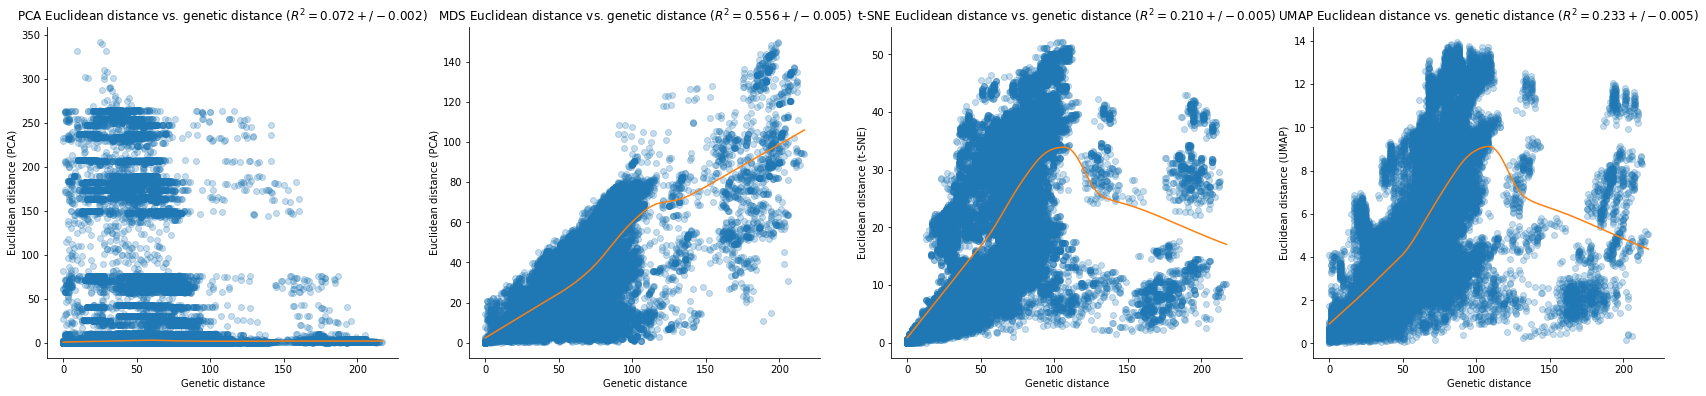

In [82]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 6))
fig.tight_layout(pad=4.0)

mean = metadata_PCA["mean"].values.tolist()[0]
std = metadata_PCA["std"].values.tolist()[0]

ax1.plot(total_df_PCA["genetic"], total_df_PCA["euclidean"], "o", alpha=0.25)
ax1.plot(total_df_PCA["LOWESS_x"], total_df_PCA["LOWESS_y"], label="LOESS")

ax1.set_xlabel("Genetic distance")
ax1.set_ylabel("Euclidean distance (PCA)")
ax1.set_title(f"PCA Euclidean distance vs. genetic distance ($R^2={mean:.3f} +/- {std:.3f}$)")


mean = metadata_MDS["mean"].values.tolist()[0]
std = metadata_MDS["std"].values.tolist()[0]

ax2.plot(total_df_MDS["genetic"], total_df_MDS["euclidean"], "o", alpha=0.25)
ax2.plot(total_df_MDS["LOWESS_x"], total_df_MDS["LOWESS_y"], label="LOESS")

ax2.set_xlabel("Genetic distance")
ax2.set_ylabel("Euclidean distance (PCA)")
ax2.set_title(f"MDS Euclidean distance vs. genetic distance ($R^2={mean:.3f} +/- {std:.3f}$)")


mean = metadata_TSNE["mean"].values.tolist()[0]
std = metadata_TSNE["std"].values.tolist()[0]

ax3.plot(total_df_TSNE["genetic"], total_df_TSNE["euclidean"], "o", alpha=0.25)
ax3.plot(total_df_TSNE["LOWESS_x"], total_df_TSNE["LOWESS_y"], label="LOESS")

ax3.set_xlabel("Genetic distance")
ax3.set_ylabel("Euclidean distance (t-SNE)")
ax3.set_title(f"t-SNE Euclidean distance vs. genetic distance ($R^2={mean:.3f} +/- {std:.3f}$)")



mean = metadata_UMAP["mean"].values.tolist()[0]
std = metadata_UMAP["std"].values.tolist()[0]

ax4.plot(total_df_UMAP["genetic"], total_df_UMAP["euclidean"], "o", alpha=0.25)
ax4.plot(total_df_UMAP["LOWESS_x"], total_df_UMAP["LOWESS_y"], label="LOESS")

ax4.set_xlabel("Genetic distance")
ax4.set_ylabel("Euclidean distance (UMAP)")
ax4.set_title(f"UMAP Euclidean distance vs. genetic distance ($R^2={mean:.3f} +/- {std:.3f}$)")


sns.despine()
plt.savefig(snakemake.output.Scatterplot)

# KDE Density Plots

In [83]:
import matplotlib.gridspec as gridspec

In [84]:
Genetic_KDE_df = pd.read_csv(KDE_genetic,index_col=0)
Genetic_KDE_metadata_df = pd.read_csv(KDE_genetic_metadata, index_col=0)
PCA_KDE_df = pd.read_csv(KDE_pca,index_col=0)
PCA_KDE_metadata_df = pd.read_csv(KDE_pca_metadata, index_col=0)
MDS_KDE_df = pd.read_csv(KDE_mds,index_col=0)
MDS_KDE_metadata_df = pd.read_csv(KDE_mds_metadata, index_col=0)
TSNE_KDE_df = pd.read_csv(KDE_tsne,index_col=0)
TSNE_KDE_metadata_df = pd.read_csv(KDE_tsne_metadata, index_col=0)
UMAP_KDE_df = pd.read_csv(KDE_umap,index_col=0)
UMAP_KDE_metadata_df = pd.read_csv(KDE_umap_metadata, index_col=0)

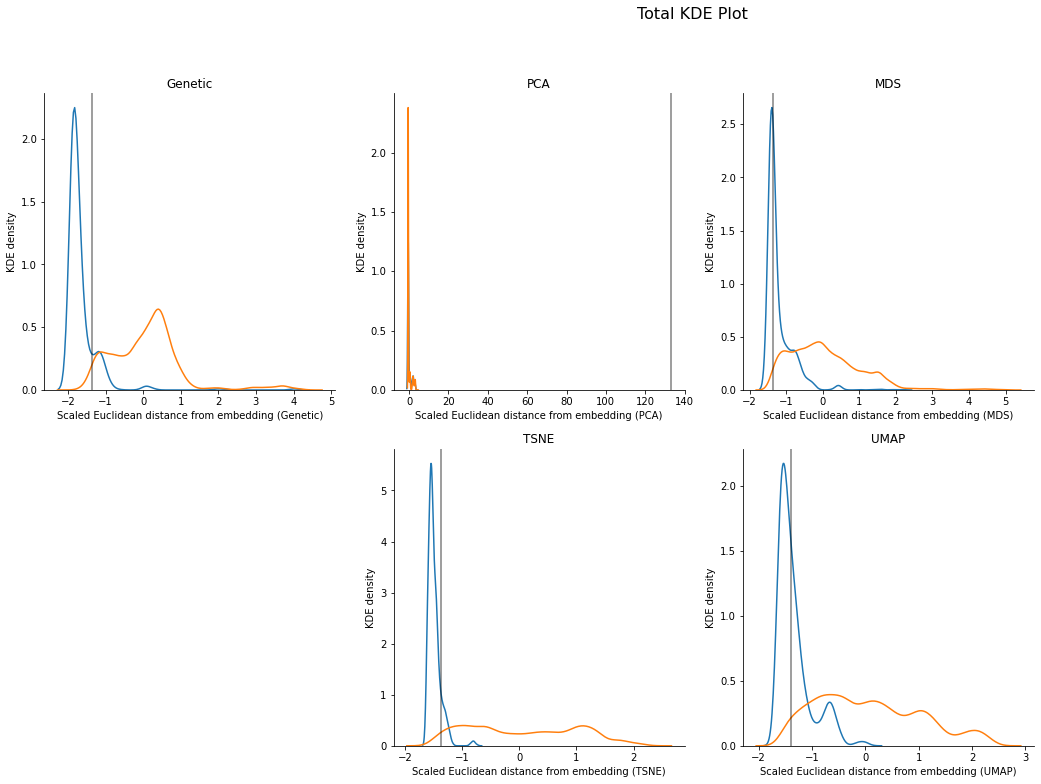

In [85]:
#fig, axes = plt.subplots(1, 5, figsize=(40, 8))
fig = plt.figure(figsize=(24, 12), constrained_layout=False)
gs = gridspec.GridSpec(2, 4, figure=fig, hspace=0.2, wspace=0.2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[1, 2])



#GENETIC 
ax1 = sns.kdeplot(Genetic_KDE_df.query("clade_status == 0")["scaled_distance"], label="Same clade", ax=ax1)
ax1 = sns.kdeplot(Genetic_KDE_df.query("clade_status == 1")["scaled_distance"], label="Different clade", ax=ax1)
ax1.axvline(x=Genetic_KDE_metadata_df["classifier_threshold"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)

ax1.set_title('Genetic')
ax1.set_xlabel("Scaled Euclidean distance from embedding (Genetic)")
ax1.set_ylabel("KDE density")

#PCA
ax2 = sns.kdeplot(PCA_KDE_df.query("clade_status == 0")["scaled_distance"], label="Same clade", ax=ax2)
ax2 = sns.kdeplot(PCA_KDE_df.query("clade_status == 1")["scaled_distance"], label="Different clade", ax=ax2)
ax2.axvline(x=PCA_KDE_metadata_df["classifier_threshold"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)

ax2.set_title('PCA')
ax2.set_xlabel("Scaled Euclidean distance from embedding (PCA)")
ax2.set_ylabel("KDE density")

#MDS
ax3 = sns.kdeplot(MDS_KDE_df.query("clade_status == 0")["scaled_distance"], label="Same clade", ax=ax3)
ax3 = sns.kdeplot(MDS_KDE_df.query("clade_status == 1")["scaled_distance"], label="Different clade", ax=ax3)
ax3.axvline(x=MDS_KDE_metadata_df["classifier_threshold"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)

ax3.set_title('MDS')
ax3.set_xlabel("Scaled Euclidean distance from embedding (MDS)")
ax3.set_ylabel("KDE density")

#TSNE
ax4 = sns.kdeplot(TSNE_KDE_df.query("clade_status == 0")["scaled_distance"], label="Same clade", ax=ax4)
ax4 = sns.kdeplot(TSNE_KDE_df.query("clade_status == 1")["scaled_distance"], label="Different clade", ax=ax4)
ax4.axvline(x=TSNE_KDE_metadata_df["classifier_threshold"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)

ax4.set_title('TSNE')
ax4.set_xlabel("Scaled Euclidean distance from embedding (TSNE)")
ax4.set_ylabel("KDE density")

#UMAP
ax5 = sns.kdeplot(UMAP_KDE_df.query("clade_status == 0")["scaled_distance"], label="Same clade", ax=ax5)
ax5 = sns.kdeplot(UMAP_KDE_df.query("clade_status == 1")["scaled_distance"], label="Different clade", ax=ax5)
ax5.axvline(x=UMAP_KDE_metadata_df["classifier_threshold"].values.tolist()[0], label="SVC threshold", color="#000000", alpha=0.5)

ax5.set_title('UMAP')
ax5.set_xlabel("Scaled Euclidean distance from embedding (UMAP)")
ax5.set_ylabel("KDE density")


fig.suptitle('Total KDE Plot', fontsize=16)
sns.despine()
plt.savefig(snakemake.output.KDE_density)

In [86]:
list_of_chart = linking_tree_with_plots_brush(merged_mds_df,['mds' + str(i) for i in range(1,11)],['MDS' + str(i) for i in range(1,11)], 'clade_membership:N', ['strain','clade_membership'])
chart = list_of_chart[0]|list_of_chart[1]|list_of_chart[2]|list_of_chart[3]|list_of_chart[4]|list_of_chart[5]

chart.save(snakemake.output.MDS_Supplement)

In [87]:
list_of_chart = linking_tree_with_plots_brush(merged_pca_df,['pca' + str(i) for i in range(1,11)],['PCA' + str(i) for i in range(1,11)], 'clade_membership:N', ['strain','clade_membership'])
chart = list_of_chart[0]|list_of_chart[1]|list_of_chart[2]|list_of_chart[3]|list_of_chart[4]|list_of_chart[5]

chart.save(snakemake.output.PCA_Supplement)